# Braintriage CNN: Pre-Trained ResNet50

# Import packages
Here we import important packages. Add any packages you need.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchvision import transforms
from torchvision import models
import os
import SimpleITK as sitk
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math as math
import csv
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


### Change dirs below to your specific case

In [3]:
# Data in & out dirs
in_dir = '/Users/jordynaus/Desktop/ismi/BrainTriage/train/full'
out_dir = '/Users/jordynaus/Desktop/ismi/out'

### Specify data directory (the same as out_dir)    
data_dir = '/Users/jordynaus/Desktop/ismi/out'

# Model Dir for saving training parameters:
model_dir = '/Users/jordynaus/Desktop/ismi/models'

# Create dataset
First we select slices from the full dataset. Here we show an example where the center slice is selected for the T1, T2 and T2-FLAIR scan. These are combined in a torch tensor to allow for quick processing by the network.

In [4]:
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
            
for klass in os.listdir(in_dir):

    for patient in os.listdir(os.path.join(in_dir, klass)):

        ## Check if patient has not been processed yet
        out_path = os.path.join(out_dir, patient+'.pt')
        if not os.path.exists(out_path):

            ## Paths to the image files
            t1_path = os.path.join(in_dir,klass,patient,'T1.mha')
            t2_path = os.path.join(in_dir,klass,patient,'T2.mha')
            t2_flair_path = os.path.join(in_dir,klass,patient,'T2-FLAIR.mha')

            ## Load all images
            t1_image = sitk.ReadImage(t1_path)
            t2_image = sitk.ReadImage(t2_path)
            t2_flair_image = sitk.ReadImage(t2_flair_path)

            ## Check if the number of slices is equal in all series
            if t1_image.GetSize()[-1] == t2_image.GetSize()[-1] == t2_flair_image.GetSize()[-1]:
                
                with open(out_dir+'/labels_slices_z.csv', 'a') as csvfile:
                    w = csv.writer(csvfile, delimiter=',')

                    if klass == 'normal':
                        w.writerow([patient, 0])
                    elif klass == 'abnormal':
                        w.writerow([patient, 1])
                
                ## Determine center slice of images
                z = int(t1_image.GetSize()[-1]/2)

                ## Convert the images to numpy arrays
                t1_array = sitk.GetArrayFromImage(t1_image)
                t2_array = sitk.GetArrayFromImage(t2_image)
                t2_flair_array = sitk.GetArrayFromImage(t2_flair_image)

                ## Extract the center slices from the images
                t1_slice = t1_array[z,:,:]
                t2_slice = t2_array[z,:,:]
                t2_flair_slice = t2_flair_array[z,:,:]

                ## Create one data array
                comb_data = np.zeros((3,512,512))
                comb_data[0,:,:] = t1_slice
                comb_data[1,:,:] = t2_slice
                comb_data[2,:,:] = t2_flair_slice
                
                ## Save as torch tensor for quick loading during training
                torch.save(torch.from_numpy(comb_data.astype('float32')),out_dir+'/'+patient+'.pt')

                
                print("Slices saved for:", patient)

                del t1_array, t2_array, t2_flair_array

            else:
                print("Number of slices not equal for:", patient)
                del t1_image, t2_image, t2_flair_image
        else:
            continue

We create a dataset class that is compatible with the 'data_loader' from PyTorch. This allows us to feed our images to the network efficiently during training and validation. We read the labels for the different patients from a CSV file and convert this into a dictionary. Based on these labels we split the data in a training and validation set (you can choose a different ratio).

In [5]:
### Define custom dataset class ###
class Dataset(data.Dataset):
  #'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels, location, transformation = None):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.loc = location
        self.transformation = transformation

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        # Load data and get label
        if(self.transformation is not None):
            X = self.transformation(torch.load(self.loc + '/' + ID + '.pt'))
        else:
            X = torch.load(self.loc + '/' + ID + '.pt')#/2749         
        y = torch.FloatTensor([self.labels[ID]])

        return X, y

### Load labels and convert to dict ###
labelsn = {}
labelsa = {}

n=0
a=0

with open(data_dir+'/labels_slices_z.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for rows in reader:
        if float(rows[1])==0 and n<500:
            n = n+1
            labelsn[rows[0]] = float(rows[1])
        elif float(rows[1])==1 and a<500:
            a = a+1
            labelsa[rows[0]] = float(rows[1])
labels = {**labelsn,**labelsa}
            
### Based on the labels, split data in training and validation set ###
IDn = np.asarray(list(labelsn.keys()))
IDa = np.asarray(list(labelsa.keys()))
n_samples = IDa.shape[0]

IDn = IDn[np.random.permutation(n_samples)]
IDa = IDa[np.random.permutation(n_samples)]

data_sets = {}
data_sets['train'] = np.concatenate((IDn[:int(0.8*n_samples)],IDa[:int(0.8*n_samples)]))
data_sets['validation'] = np.concatenate((IDn[int(0.8*n_samples):],IDa[int(0.8*n_samples):]))


train_transforms = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
training_set = Dataset(data_sets['train'], labels, data_dir, train_transforms)
validation_set = Dataset(data_sets['validation'], labels, data_dir, train_transforms)

You can visually inspect the data by making a plot of a scan.

torch.Size([3, 512, 512])


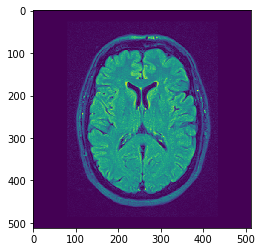

In [6]:
import matplotlib
import matplotlib.pyplot as plt

X = torch.load(data_dir + '/' + '16' + '.pt')#/2749
print(X.shape)
plt.figure()
plt.imshow(X.data.numpy()[2,:,:])

# Defining the model

When using a Pre-Trained ResNet-50, we only need to make sure that our network has correct final layers (so: correct input shape, correct output shape)

In [7]:
class Net(nn.Module):
    
    def __init__(self, model):
        super(Net, self).__init__()
        self.model = model
        fc_in = model.fc.in_features
        
        # Remove last layer of original model
        self.model = nn.Sequential(*list(model.children())[:-1])
 
        # Final layers
        self.fc1 = nn.Linear(2048, 128)  
        self.fc2 = nn.Linear(128,1)
        #self.sm1 = nn.Softmax(1)

    
    def forward(self, x):
        x = self.model(x)
        
        # Turn x into the right shape
        x = x.view(x.size(0), -1)
        
        # Put output x through our self defined layers
        x = self.fc1(x)
        out = self.fc2(x)
        
        return out

# Initialize model
Here we set the different training and model parameters. The model is initialized and a loss function and optimizer are choosen. Finally a training and validation iterator is created. In the cell below this cell, we initialize ResNet-50 pre-trained model.

In [8]:
# ### Parameters ###
device = 0
epochs = 10
batch_size = 5
in_channels = 3
outsize = 1



# Load Pre-Trained ResNet-50
model = models.resnet50(pretrained=True)

# Change the Pre-Trained Model to our own Defined Model
model = Net(model)

# ### Loss and optimizer ###
criterion = nn.BCEWithLogitsLoss()#nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

# ### Create data generator ###
training_iterator = data.DataLoader(training_set, batch_size=batch_size, shuffle = True)
validation_iterator = data.DataLoader(validation_set, batch_size=batch_size, shuffle = False)

# Training and validation
In the next cell the model is trained and validated. The loss is printed and the model is saved after every epoch.

In [ ]:
### Training and validation ###
from torch.autograd import Variable
m =nn.Sigmoid()

loss_history = {'training': [], 'validation': []}
acc_history = {'training': [], 'validation': []}

for j in range(epochs):
    loss_history['training'].append(0)
    acc_history['training'].append(0)

    for i, batch in enumerate(training_iterator):

        model.train()

        images, targets = batch[0] , batch[1]
        
        y = model(images)
        
        loss = criterion(y,targets)

        optimizer.zero_grad()
        loss.backward()

        #print(list(model.parameters())[0].grad)
        optimizer.step()
        
        #Accuracy
        output = (m(y)>0.5).float()
        #print(output)

        correct = (output == targets).float().sum()/output.shape[0]

        loss_history['training'][-1] += float(loss.data)
        acc_history['training'][-1] += float(correct)

        #print(loss.data)
    loss_history['training'][-1] /= i + 1
    acc_history['training'][-1] /= i + 1

    loss_history['validation'].append(0)
    acc_history['validation'].append(0)

    for i, batch in enumerate(validation_iterator):

        model.eval()
        
        images, targets = batch[0], batch[1]

        y = model(images)
        loss = criterion(y,targets)
        
        #Accuray
        output = (m(y)>0.5).float()
        correct = (output == targets).float().sum()/output.shape[0]
        #print(output)
        loss_history['validation'][-1] += float(loss.data)
        acc_history['validation'][-1] += float(correct)

    loss_history['validation'][-1] /= i + 1
    acc_history['validation'][-1] /= i + 1

    print('epoch: {:3d} / {:03d}, training loss: {:.4f}, validation loss: {:.4f}, training accuracy: {:.3f}, validation accuracy: {:.3f}.'.format(j + 1, epochs, loss_history['training'][-1], loss_history['validation'][-1], acc_history['training'][-1], acc_history['validation'][-1]))
    np.savez('{:s}/loss_history_{:03d}.npz'.format(model_dir, j), loss_history)
    torch.save(model.state_dict(), '{:s}/model_{:03d}.npz'.format(model_dir, j))

    

# Testing
Here we show some example code that you can use to run your model on the test data set once this is provided and create a .csv submission file that you can upload to grand challenge.

# Select slices for test set
Here we do the same as above to select slices from the test set.

In [ ]:
in_dir = 'path/to/test_in_dir'
out_dir = 'path/to/test_out_dir'


if not os.path.exists(out_dir):
    os.makedirs(out_dir)
            
for klass in os.listdir(in_dir):

    for patient in os.listdir(os.path.join(in_dir, klass)):

        ## Check if patient has not been processed yet
        out_path = os.path.join(out_dir, patient+'.pt')
        if not os.path.exists(out_path):

            ## Paths to the image files
            t1_path = os.path.join(in_dir,klass,patient,'T1.mha')
            t2_path = os.path.join(in_dir,klass,patient,'T2.mha')
            t2_flair_path = os.path.join(in_dir,klass,patient,'T2-FLAIR.mha')

            ## Load all images
            t1_image = sitk.ReadImage(t1_path)
            t2_image = sitk.ReadImage(t2_path)
            t2_flair_image = sitk.ReadImage(t2_flair_path)

            ## Check if the number of slices is equal in all series
            if t1_image.GetSize()[-1] == t2_image.GetSize()[-1] == t2_flair_image.GetSize()[-1]:
                
                with open(out_dir+'/labels_slices_z_test.csv', 'a') as csvfile:
                    w = csv.writer(csvfile, delimiter=',')

                    if klass == 'normal':
                        w.writerow([patient, 0])
                    elif klass == 'abnormal':
                        w.writerow([patient, 1])
                
                ## Determine center slice of images
                z = int(t1_image.GetSize()[-1]/2)

                ## Convert the images to numpy arrays
                t1_array = sitk.GetArrayFromImage(t1_image)
                t2_array = sitk.GetArrayFromImage(t2_image)
                t2_flair_array = sitk.GetArrayFromImage(t2_flair_image)

                ## Extract the center slices from the images
                t1_slice = t1_array[z,:,:]
                t2_slice = t2_array[z,:,:]
                t2_flair_slice = t2_flair_array[z,:,:]

                ## Create one data array
                comb_data = np.zeros((3,512,512))
                comb_data[0,:,:] = t1_slice
                comb_data[1,:,:] = t2_slice
                comb_data[2,:,:] = t2_flair_slice
                
                ## Save as torch tensor for quick loading during training
                torch.save(torch.from_numpy(comb_data.astype('float32')),out_dir+'/'+patient+'.pt')

                
                print("Slices saved for:", patient)

                del t1_array, t2_array, t2_flair_array

            else:
                print("Number of slices not equal for:", patient)
                del t1_image, t2_image, t2_flair_image
        else:
            continue

We create a test dataset from these slices.

In [ ]:
### Specify test data directory ###    
test_dir = '/path/to/test_out_dir'

### Load labels and convert to dict ###
labels_test = {}

with open(test_dir+'/labels_slices_z_test.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for rows in reader:
        labels_test[rows[0]] = float(rows[1])
           
data_sets['test'] = np.asarray(list(labels_test.keys()))

test_set = Dataset(data_sets['test'], labels_test, test_dir)


# Run trained model on the test set.
Run the model with the best validation loss on the test set to obtain a 'submission' csv file. You can upload this file to grand challenge to see how well you perform and add your score to the leaderboard.

In [ ]:
test_iterator = data.DataLoader(test_set, batch_size=1, shuffle = False)

j = 4
model = Model(in_channels,outsize).cuda() # if device < 0 else Model(1,outsize).to_gpu(device)
checkpoint = torch.load('{:s}/model_{:03d}.npz'.format(model_dir, j))

model.load_state_dict(checkpoint)
model.eval()
m =nn.Sigmoid()

with open(test_dir+'/submission.csv', 'a') as csvfile:
    w = csv.writer(csvfile, delimiter=',')
    w.writerow(['case','probability','class'])
    for i, batch in enumerate(test_iterator):
        images, targets = batch[0].cuda() , batch[1].cuda()
        y = model(images)
        prob = m(y)
        output = prob>0.5
        patient = data_sets['test'][i]
        w.writerow([patient, float(prob), int(output)])